## 1. Scope:
- Analyze what factor affect the length of the trip for Florida uber market
- Longer the miles, the more money could be earned, this could help prioritize potential trip that make more money?
- The longer the trip could be used to adjust the price
- Group by location, count the number of trip could be used to allocate resources

## 2. Gather Data

In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

df = pd.read_csv('UberDataset.csv')
display(df.head())

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
0,01-01-2016 21:11,01-01-2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,01-02-2016 01:25,01-02-2016 01:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,01-02-2016 20:25,01-02-2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,01-05-2016 17:31,01-05-2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,01-06-2016 14:42,01-06-2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


## 3. Clean data

In [203]:
# Incorrect data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   START_DATE  1156 non-null   object 
 1   END_DATE    1155 non-null   object 
 2   CATEGORY    1155 non-null   object 
 3   START       1155 non-null   object 
 4   STOP        1155 non-null   object 
 5   MILES       1156 non-null   float64
 6   PURPOSE     653 non-null    object 
dtypes: float64(1), object(6)
memory usage: 63.3+ KB


In [204]:
df['START_DATE'] = df['START_DATE'].str.replace('/','-')
df['START_DATE'] = pd.to_datetime(df['START_DATE'], errors = 'coerce')
df['END_DATE'] = df['END_DATE'].str.replace('/','-') 
df['END_DATE'] = pd.to_datetime(df['END_DATE'], errors = 'coerce')

In [205]:
# Missing value 
df.isna().sum()

START_DATE      1
END_DATE        1
CATEGORY        1
START           1
STOP            1
MILES           0
PURPOSE       503
dtype: int64

In [206]:
# if missing data is < 5% of the col data, we can drop the missing data in that col
threshold = len(df)*0.005
col_drop = df.columns[df.isna().sum() <= threshold]
print(col_drop)
df.dropna(subset = col_drop, inplace = True)
df.isna().sum()

Index(['START_DATE', 'END_DATE', 'CATEGORY', 'START', 'STOP', 'MILES'], dtype='object')


START_DATE      0
END_DATE        0
CATEGORY        0
START           0
STOP            0
MILES           0
PURPOSE       502
dtype: int64

In [207]:
# case: a lot of missing data in a col
df.groupby('CATEGORY')['PURPOSE'].value_counts()
purpose_mode = df.groupby('CATEGORY')['PURPOSE'].apply(lambda x: x.mode()[0] if not x.mode().empty else 'Other')
df['PURPOSE'] = df['PURPOSE'].fillna(df['CATEGORY'].map(purpose_mode))
df.PURPOSE.value_counts(dropna=False)

PURPOSE
Meeting            618
Meal/Entertain     160
Errand/Supplies    128
Customer Visit     101
Moving              75
Temporary Site      50
Between Offices     18
Airport/Travel       3
Charity ($)          1
Commute              1
Name: count, dtype: int64

In [208]:
# Duplicate data
df.duplicated().sum()
df = df[~df.duplicated()]

In [209]:
# Outliers
df.MILES.describe()

count    1154.000000
mean       10.567418
std        21.588452
min         0.500000
25%         2.900000
50%         6.000000
75%        10.400000
max       310.300000
Name: MILES, dtype: float64

In [210]:
mean = df.MILES.mean()
std = df.MILES.std()
outliers = (df.MILES - mean) > 3*std
df = df[~outliers]

## 4. Explore data analysis

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1132 entries, 0 to 1154
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   START_DATE  1132 non-null   datetime64[ns]
 1   END_DATE    1132 non-null   datetime64[ns]
 2   CATEGORY    1132 non-null   object        
 3   START       1132 non-null   object        
 4   STOP        1132 non-null   object        
 5   MILES       1132 non-null   float64       
 6   PURPOSE     1132 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 70.8+ KB


### Numerical/Target

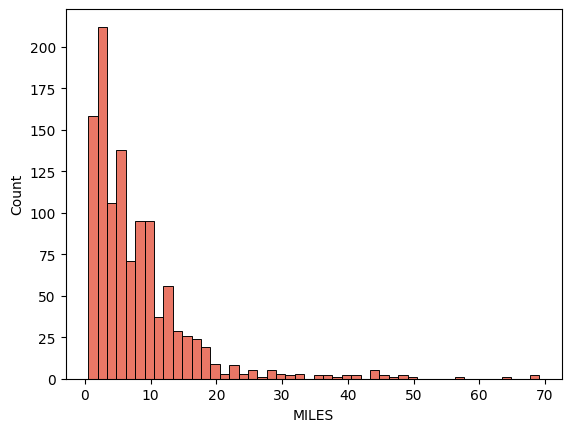

In [212]:
sns.histplot(df['MILES'])
plt.show() # highly skewed -> need to transform

<Axes: xlabel='log_miles', ylabel='Count'>

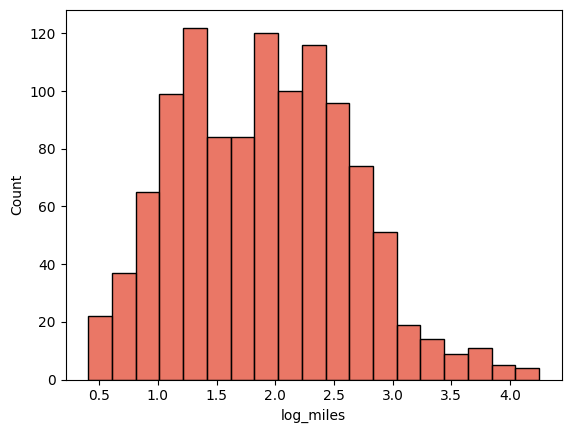

In [213]:
import numpy as np
df['log_miles'] = np.log(df['MILES']+1)
sns.histplot(df['log_miles']) # the result distribution is more normal

### Categories

CATEGORY
Business    1056
Personal      76
Name: count, dtype: int64


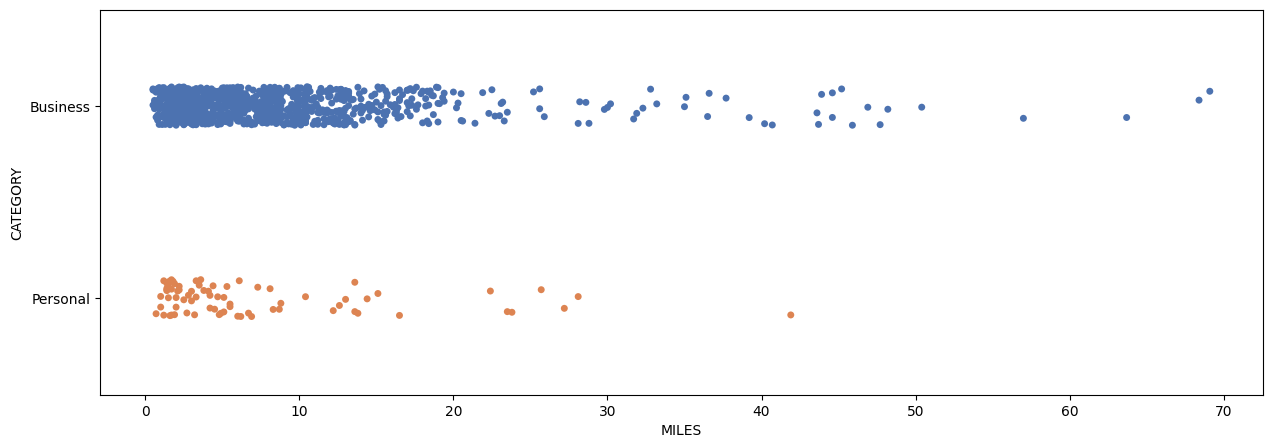

In [214]:
# CATEGORY
fig, ax = plt.subplots(1, figsize = (15,5))
sns.set_palette("deep")

print(df.CATEGORY.value_counts())

sns.stripplot(data=df, 
              y='CATEGORY', 
              x='MILES', 
              hue='CATEGORY', ax = ax)

plt.show()

- Most are business trip 
- The business could be further than personal

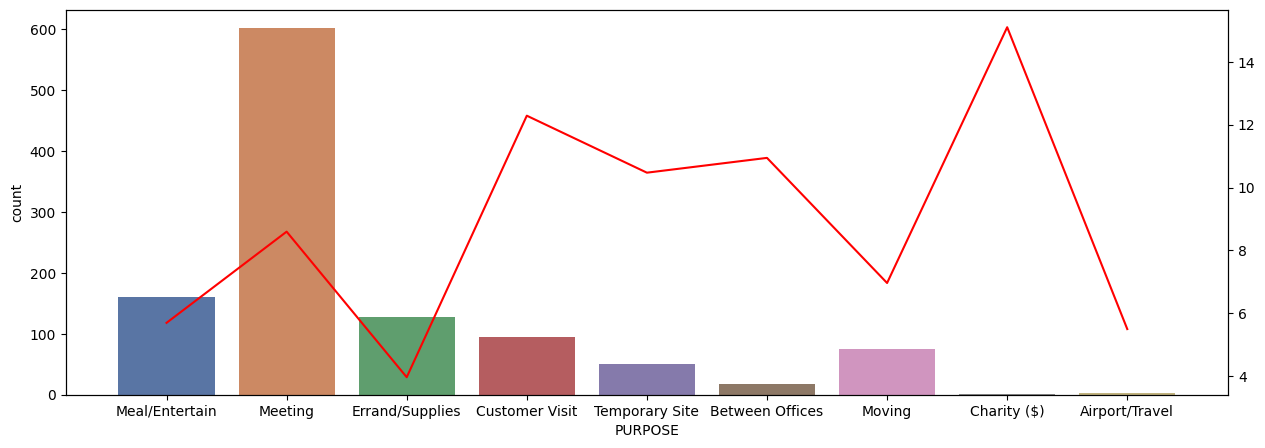

In [215]:
# PURPOSE
fig, ax = plt.subplots(figsize = (15,5))
sns.set_palette("deep")
sns.countplot(data = df,    
              x = 'PURPOSE',
              hue = 'PURPOSE',
              ax = ax)

ax1 = ax.twinx()
df_mean = df.groupby('PURPOSE')['MILES'].mean()
sns.lineplot(x = df_mean.index, 
            y = df_mean.values, 
            color = 'red',
            ax= ax1)
plt.xticks(rotation = 90)
plt.show()


- High amount of ride for meeting purpose, then meal/entrance
- High mile average for commuting purpose and customer visit

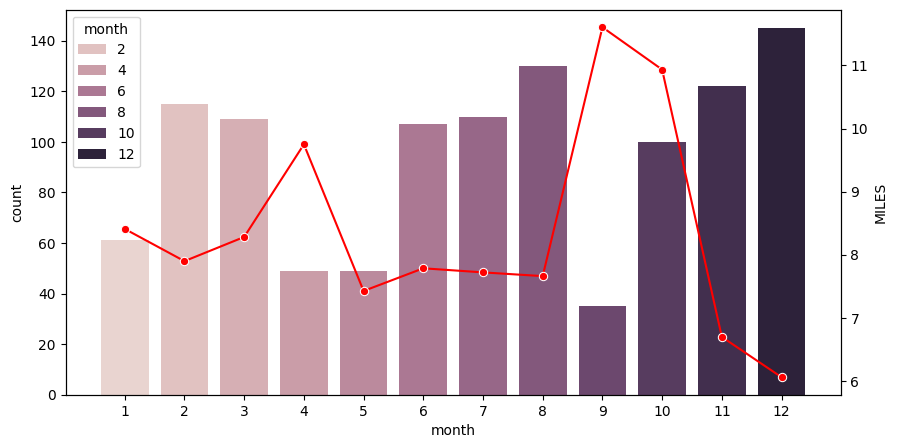

In [216]:
# time-month
sns.set_palette("BrBG")
fig, ax1 = plt.subplots(figsize=(10, 5))

# Create a count plot
df['month'] = df['START_DATE'].dt.month
sns.countplot(data=df, x='month', ax=ax1, hue = 'month')

# Calculate mean miles per month
df_mean = df.groupby('month')['MILES'].mean().reset_index()
df_mean['month'] = df_mean['month']-1

# Create a secondary y-axis
ax2 = ax1.twinx()
sns.lineplot(x='month', y='MILES', data=df_mean, ax=ax2, color='red', marker='o')

plt.show()

- The amount of trip increases within a 4 month period
- The longest travel mile during 10 and 11 and 5

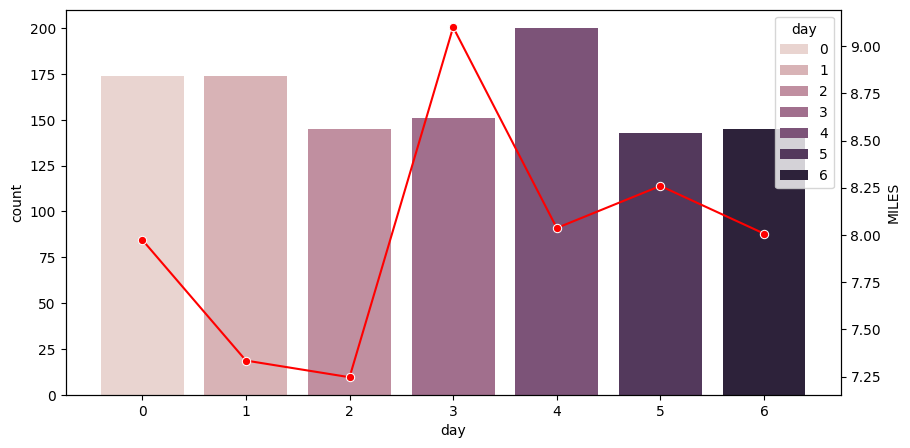

In [217]:
# time-day
fig, ax1 = plt.subplots(figsize=(10, 5))
df['day'] = df['START_DATE'].dt.weekday
sns.countplot(data=df, x='day', ax=ax1, hue = 'day')

ax2 = ax1.twinx()
day_mean = df.groupby('day')['MILES'].mean().reset_index()
sns.lineplot(x= 'day', y = 'MILES', data = day_mean, ax = ax2, color = 'red', marker = 'o') 
plt.show()

### Correlation

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1132 entries, 0 to 1154
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   START_DATE  1132 non-null   datetime64[ns]
 1   END_DATE    1132 non-null   datetime64[ns]
 2   CATEGORY    1132 non-null   object        
 3   START       1132 non-null   object        
 4   STOP        1132 non-null   object        
 5   MILES       1132 non-null   float64       
 6   PURPOSE     1132 non-null   object        
 7   log_miles   1132 non-null   float64       
 8   month       1132 non-null   int32         
 9   day         1132 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(2), object(4)
memory usage: 88.4+ KB


<Axes: >

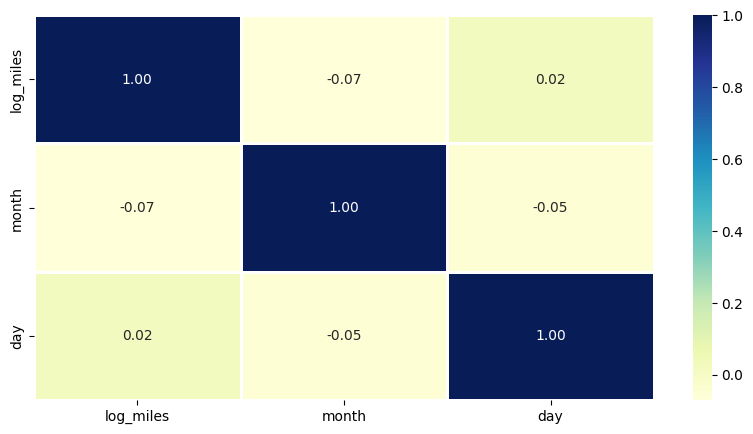

In [219]:
# Correlation of numerical columns
df_num = df[['log_miles', 'month', 'day']]

plt.figure(figsize = (10,5))
sns.heatmap(df_num.corr(),
            cmap = 'YlGnBu',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

there are no clear corellation

<Axes: >

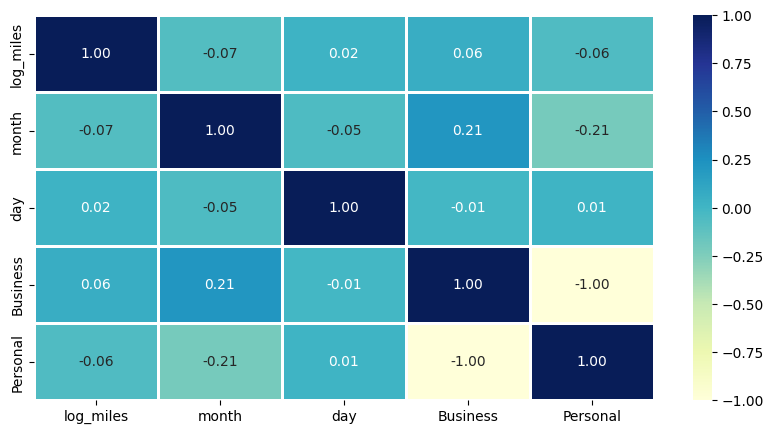

In [220]:
# Encode the categorical columns to conduct correlation
cat_dum = pd.get_dummies(df['CATEGORY'])
df_num = pd.concat([df_num, cat_dum],axis = 1)
plt.figure(figsize = (10,5))

sns.heatmap(df_num.corr(),
            cmap = 'YlGnBu',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

- only comute show slight correlation to miles


<Axes: >

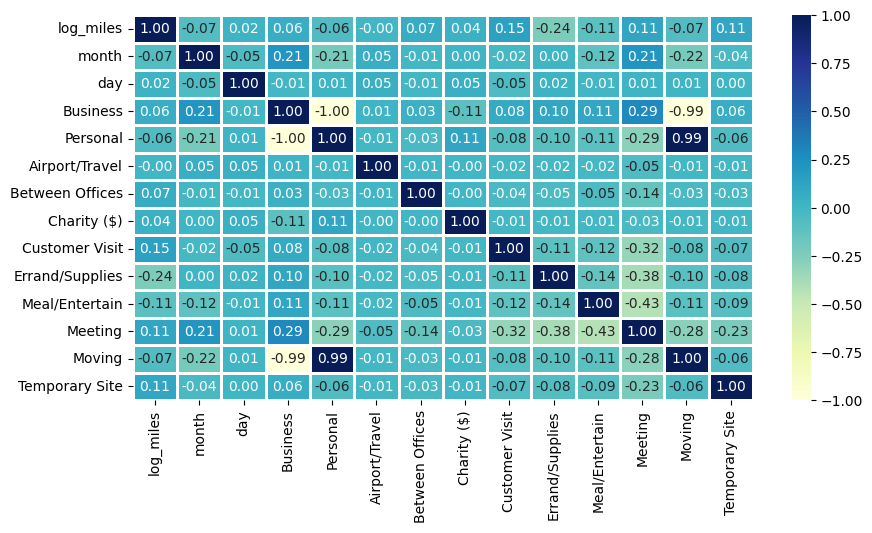

In [221]:
pur_dum = pd.get_dummies(df['PURPOSE'])
df_num = pd.concat([df_num, pur_dum],axis = 1)
plt.figure(figsize = (10,5))

sns.heatmap(df_num.corr(),
            cmap = 'YlGnBu',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

Summary
- Most are business trip
- The business could be further than personal
- High amount of ride for meeting purpose, then meal/entrance
- High mile average for commuting purpose and customer visit
- Most book during afternoon and evening
- The amount of trip ins increase from 9 - 12
- The longest travel mile during 4-6
- longe travel near the end of the week

Potential ideas:

- Trip Purpose Classification:
Build a classification model to predict the purpose of each trip (e.g., business, personal, meeting, customer visit) based on features such as miles traveled, total amount spent, and time of booking. 
It can prioritize commuting trips, meeting trips, or customer visit trips based on their importance and demand.
Enhanced Customer Experience, it can offer special discounts or promotions for commuting trips, provide priority boarding for meeting trips, or offer additional amenities for customer visit trips.

- Demand Forecasting:
Use machine learning to forecast future trip demand based on historical booking data, seasonal trends, and external factors to optimize resource allocation and service capacity.

## 5. Modeling

### Prepare X and y

In [222]:
y = df['log_miles']
X = df_num.astype(float).drop(columns = 'log_miles')    
X

,month,day,Business,Personal,Airport/Travel,Between Offices,Charity ($),Customer Visit,Errand/Supplies,Meal/Entertain,Meeting,Moving,Temporary Site
0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,12.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1151,12.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1152,12.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1153,12.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Feature engineering


In [223]:
# time-hour
df['time'] = df['START_DATE'].dt.hour
df['day-night'] = pd.cut(x = df['time'],
                         bins = [-0.0001,10,15,19,24],
                         labels = ['morning','afternoon','evening','night'])
df['day-night'].value_counts()

day-night
afternoon    422
evening      337
morning      200
night        173
Name: count, dtype: int64

In [224]:
X = pd.concat([X, pd.get_dummies(df['day-night'], drop_first=True).astype(float)], axis = 1)

### Train model

In [225]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
lr = LinearRegression()
lr.fit(X_train, y_train)

X_train_sm = sm.add_constant(X_train)  # adding a constant
model = sm.OLS(y_train, X_train_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_miles   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     10.30
Date:                Wed, 01 Jan 2025   Prob (F-statistic):           1.63e-20
Time:                        18:54:51   Log-Likelihood:                -932.90
No. Observations:                 905   AIC:                             1894.
Df Residuals:                     891   BIC:                             1961.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.4312      0.105     

In [228]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.01)
lasso.fit(X_train, y_train)
lasso.coef_ # the coefficients of the features

array([-2.39069125e-02,  5.34077937e-04,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.47731229e-01,
       -4.58314369e-01, -2.33807461e-01,  0.00000000e+00, -1.61491789e-01,
        5.90499135e-02, -1.77323335e-04, -3.71659590e-02,  0.00000000e+00])

### Evaluate model

In [229]:
from sklearn.metrics import mean_squared_error
y_linear = lr.predict(X_test)
y_lasso = lasso.predict(X_test)

print('Linear Regression MSE:', mean_squared_error(y_test, y_linear))
print('Lasso MSE:', mean_squared_error(y_test, y_lasso))

Linear Regression MSE: 0.5039563172436242
Lasso MSE: 0.5051082292239963
